In [1]:
import os
# import jwt
# import uuid
import json
import requests
from pprint import pprint
from datetime import datetime as dt, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import time
import math

import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.offline as pyo
# Set notebook made to work in offline
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [2]:
def get_ticker(m='true'):
    '''
    m : market_warning(유의종목여부) : 'false'/'true'(기본값)
    '''
    url = f"https://api.upbit.com/v1/market/all?isDetails={m}"
    headers = {"Accept": "application/json"}
    try:
        response = requests.request("GET", url, headers=headers)
        df = pd.DataFrame(json.loads(response.text))
        return df
    except Exception as e:
        print('error ', e)

In [3]:
ticker = get_ticker()

In [4]:
ticker.head()

,market_warning,market,korean_name,english_name
0,NONE,KRW-BTC,비트코인,Bitcoin
1,NONE,KRW-ETH,이더리움,Ethereum
2,NONE,BTC-ETH,이더리움,Ethereum
3,CAUTION,BTC-LTC,라이트코인,Litecoin
4,NONE,BTC-XRP,리플,Ripple


In [5]:
def get_top_n(n):
    
    url = f"https://api.upbit.com/v1/ticker"
    print(url)
    headers = {"Accept": "application/json"}
    
    x = []
    a = get_ticker().shape[0] # 전체행수
    b = math.ceil(a/200) # 전체행을 200(데이터요청최대갯수)으로 나눈값
    for i in range(0,b+1):
        c = int(a/b * i)
        if c < a: 
            x.append(c)
        else:
            x.append(a)
 
    t = -len(x)
    while t < -1: 
        
        try:
            querystring = {'markets':list(get_ticker()['market'])[x[t]:x[t+1]]}
            response = requests.request("GET", url, headers=headers, params = querystring)
            if t == -len(x):
                df = pd.DataFrame(json.loads(response.text))
            else:
                df_1 = pd.DataFrame(json.loads(response.text))
                df = pd.concat([df, df_1], axis=0)
        except Exception as e:
            print('error ', e)
    
        t += 1
        
    df.sort_values('acc_trade_volume_24h', ascending=False, inplace=True)
    
    return df[['market', 'trade_date','acc_trade_price_24h', 'acc_trade_volume_24h']].iloc[:n]

In [6]:
top_n = get_top_n(100)
top_n.head()

https://api.upbit.com/v1/ticker


,market,trade_date,acc_trade_price_24h,acc_trade_volume_24h
115,KRW-BTT,20220529,5.642395e+08,4.207104e+11
107,KRW-XEC,20220529,4.732141e+09,7.864885e+10
95,KRW-MFT,20220529,4.923510e+10,8.150838e+09
89,KRW-IQ,20220529,1.136013e+10,1.513323e+09
72,KRW-SC,20220529,7.430668e+09,1.094814e+09


In [7]:
def get_chunk(ticker:str, scale:str, tick:int, to:str, n_data=200) -> pd.DataFrame:
    
    '''
    @ Parameter 
    ticker : str : 마켓이름
    scale : str : 분/일/주/월 기간선택 'minutes'/'days'/'weeks'/'months'
    tick : int : 분단위 scale이 분일때만 사용
    to : str : 마지막 캔들 시각
    n_data : int : 캔들 갯수 최대 200
    '''
    
    if scale == 'minutes':
        url = f"https://api.upbit.com/v1/candles/minutes/{tick}"
        
    else:
        url = f"https://api.upbit.com/v1/candles/{scale}"
        
    querystring = {"market":ticker, "count":min(n_data,200), "to":f"{to}"}
    headers = {"Accept": "application/json"}
    
    try:
        response = requests.request("GET", url, headers=headers, params=querystring)
        df = pd.DataFrame(json.loads(response.text))
        df = df.sort_values(by='candle_date_time_kst')
  
        # rolling 함수 확인
        df['MA5'] = df['trade_price'].rolling(5).mean()
        df['MA20'] = df['trade_price'].rolling(20).mean()
        df['MA60'] = df['trade_price'].rolling(60).mean()
        
        return df
    except Exception as e:
        # print('error ',e)
        pass  

In [8]:
def get_data(ticker:str, scale:str, tick:int, to:str, n_data=200, t=1):
    
    '''
    @ Parameter 
    ticker : str : 마켓이름
    scale : str : 분/일/주/월 기간선택 'minutes'/'days'/'weeks'/'months'
    tick : int : 분단위 scale이 분일때만 사용
    to : str : 마지막 캔들 시각
    n_data : int : 캔들 갯수 최대 200
    t : int : n_data을 몇번 실행할것인지 정의
    '''
    
    try:
        for i in range(t):
            if i == 0:
                df = get_chunk(ticker, scale, tick, to, min(n_data,200))
            else:
                d1 = dt.strptime(to,'%Y-%m-%d %H:%M:%S')

                if scale == 'minutes':
                    d2 = timedelta(minutes=min(n_data,200))
                elif scale == 'days':
                    d2 = timedelta(days=min(n_data,200))
                elif scale == 'weeks':
                    d2 = timedelta(weeks=min(n_data,200))
                elif scale == 'months':
                    d2 = relativedelta(months=min(n_data,200))

                to = (d1-d2).strftime('%Y-%m-%d %H:%M:%S')

                df_1 = get_chunk(ticker, scale, tick, to, min(n_data,200))
                df = pd.concat([df,df_1], axis=0) 
                
        df.sort_values(by='candle_date_time_kst', ascending=False, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df
    
    except Exception as e:
        # print('error ', e)
        pass

In [10]:
# # ('KRW-BTC','minutes',1,'2022-03-28 00:00:00', 10)
# a = get_data('KRW-ETH','minutes',1,'2022-03-28 00:00:00', 200, 3)
# a.shape

eth_df = get_data('KRW-ETH','days',1,'2022-05-30 00:00:00', 200, 15)
eth_df.shape

(1705, 16)

In [11]:
eth_df['date_kst'] = eth_df['candle_date_time_kst'].str[0:10]
eth_df['date_kst'] = pd.to_datetime(eth_df['date_kst'],format='%Y-%m-%d')
eth_df['date_utc'] = eth_df['candle_date_time_utc'].str[0:10]
eth_df['date_utc'] = pd.to_datetime(eth_df['date_utc'],format='%Y-%m-%d')

In [12]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   market                   1705 non-null   object        
 1   candle_date_time_utc     1705 non-null   object        
 2   candle_date_time_kst     1705 non-null   object        
 3   opening_price            1705 non-null   float64       
 4   high_price               1705 non-null   float64       
 5   low_price                1705 non-null   float64       
 6   trade_price              1705 non-null   float64       
 7   timestamp                1705 non-null   int64         
 8   candle_acc_trade_price   1705 non-null   float64       
 9   candle_acc_trade_volume  1705 non-null   float64       
 10  prev_closing_price       1704 non-null   float64       
 11  change_price             1699 non-null   float64       
 12  change_rate              1705 non-

In [20]:
# 저장
eth_df.to_csv ("/content/drive/MyDrive/Colab Notebooks/실무인증/eth_df_20220528.csv", index = None)

In [ ]:
top_n_close = []
input_day = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
for i, ticker in enumerate(list(get_top_n(100)['market'])):
    time.sleep(0.5)
    if i % 10 == 0:
        print(f"i={i}")
    top_n_close.append(get_data(ticker, 'days',1,input_day, 200, 2))

In [ ]:
def get_min_date(x):
    return x['candle_date_time_kst'].min()

[get_min_date(x) for x in top_n_close if x is not None]

In [ ]:
top_n_close[70]

In [ ]:
def plot_bitcoin(coin, data):
    candle = go.Candlestick(x = data['candle_date_time_kst'], 
                            open = data['opening_price'],
                            high = data['high_price'],
                            low = data['low_price'],
                            close = data['trade_price'],
                            increasing_line_color = 'red', # 상승봉 스타일링
                            decreasing_line_color = 'blue' # 하락봉 스타일링
                           )
    fig = ms.make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
    if 'MA5' in data.columns:
        ma5 = go.Scatter(x = data['candle_date_time_kst'], y=data['MA5'], line=dict(color='black', width=0.8), name='ma5')
        ma20 = go.Scatter(x = data['candle_date_time_kst'], y=data['MA20'], line=dict(color='red', width=0.9), name='ma20')
        ma60 = go.Scatter(x = data['candle_date_time_kst'], y=data['MA60'], line=dict(color='green', width=1), name='ma60')
        fig.add_trace(ma5, row=1, col=1)
        fig.add_trace(ma20, row=1, col=1)
        fig.add_trace(ma60, row=1, col=1)
    fig.add_trace(candle, row=1, col=1)
    volume_bar = go.Bar(x=data['candle_date_time_kst'], y=data['candle_acc_trade_volume'])
    

    fig.add_trace(volume_bar, row=2, col=1)
    fig.update_layout(
        autosize = False,
        height = 600,
        title=f'{coin} price',
        yaxis1_title='Price',
        yaxis2_title='Volume',
        xaxis2_title='periods',
        xaxis1_rangeslider_visible=False,
        xaxis2_rangeslider_visible=True,    
    )
    fig.show()

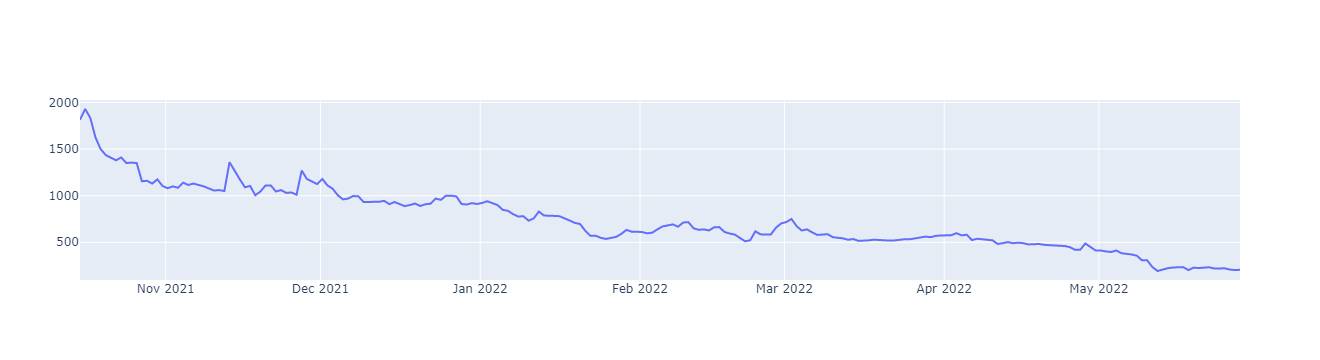

In [ ]:
i = 63
if top_n_close[i] is not None:
    fig = go.Figure(
        go.Scatter(
            x = top_n_close[i]['candle_date_time_kst'], 
            y = top_n_close[i]['trade_price']
        )
    )
    fig.show()

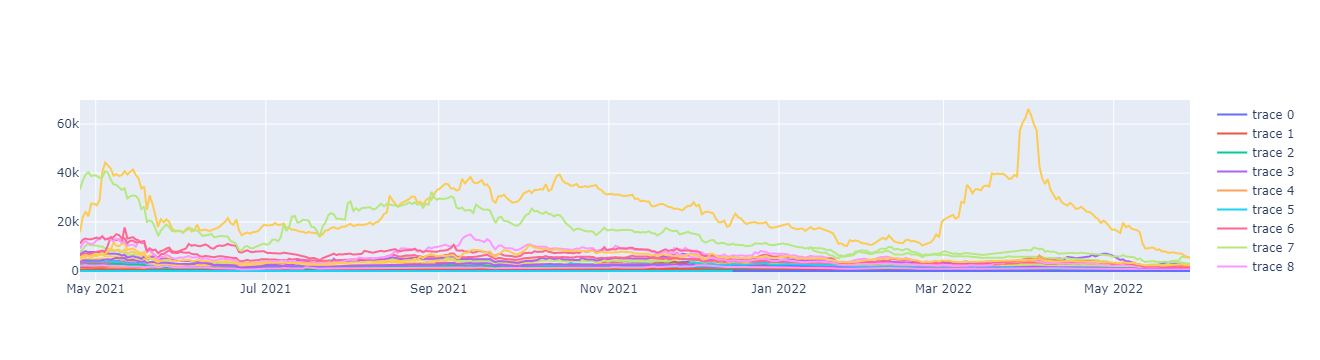

In [ ]:
import plotly.express as px
import numpy as np

start = 10
fig = go.Figure(go.Scatter(x = top_n_close[start]['candle_date_time_kst'], 
            y = top_n_close[start]['trade_price']))
for i in np.arange(start, len(top_n_close)):
    if top_n_close[i] is not None:
        tmp = top_n_close[i]
        tmp.sort_values('candle_date_time_kst', inplace=True)
        fig.add_scatter(x = top_n_close[i]['candle_date_time_kst'], 
                y = top_n_close[i]['trade_price'])
fig.show()